In [48]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os

utils.default_plot_format()
utils.pd_display_settings(3)

In [49]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"

In [50]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [51]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
display(median_pivot.tail(2))

metric,id,DPN,ApEn,D2,DFA α1,DFA α2,HF Peak Frequency,HF Power,LF Peak Frequency,LF Power,...,RMSSD,S,SD1,SD1÷SD2,SD2,SDRR,SampEn,VLF Peak Frequency,VLF Power,pNN50 (%)
24,39,True,0.76,-3.26,1.00,1.04,0.37,0.000315,0.0684,2.24e-05,...,15.39,1059,10.88,0.37,35.53,26.09,0.72,0.03,5.73e-06,0.41
25,40,True,1.06,-2.75,0.97,0.97,0.36,0.000409,0.12,3.01e-05,...,35.41,4993,25.04,0.43,67.59,50.84,1.03,0.03,3.19e-06,7.41


In [52]:
from sklearn.cluster import KMeans
clusters = 2
 
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(median_pivot)
 
print(kmeans.labels_)

[1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1]


In [53]:
from sklearn.decomposition import PCA
pca = PCA(3)
pca.fit(median_pivot)
 
pca_data = pd.DataFrame(pca.transform(median_pivot))
 
print(pca_data.head())

          0     1      2
0    703.28 21.71   4.03
1  -9300.75 21.22  -0.27
2   -748.30 16.44  -0.23
3 -11361.31 15.60 -10.03
4  -6864.78 19.56  -1.76


In [54]:

from matplotlib import colors as mcolors
import math
  
''' Generating different colors in ascending order 
                                of their hsv values '''
colors = list(zip(*sorted((
                    tuple(mcolors.rgb_to_hsv(
                          mcolors.to_rgba(color)[:3])), name)
                     for name, color in dict(
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS
                                                      ).items())))[1]
  
  
# number of steps to taken generate n(clusters) colors 
skips = math.floor(len(colors[5 : -5])/clusters)
cluster_colors = colors[5 : -5 : skips]


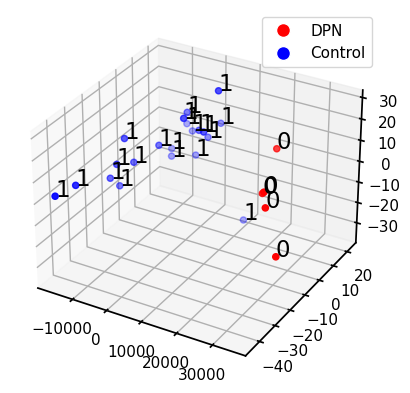

In [59]:
cluster_colors = ['red', 'blue']

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[0], pca_data[1], pca_data[2], 
                   c=list(map(lambda label: cluster_colors[label], kmeans.labels_)))
  
str_labels = list(map(lambda label: '% s' % label, kmeans.labels_))
  
list(map(lambda data1, data2, data3, str_label:
                 ax.text(data1, data2, data3, s=str_label, size=16.5,
                                 zorder=20, color='k'), pca_data[0], pca_data[1],
                 pca_data[2], str_labels))

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='DPN'),
                                        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Control')])

plt.show()
